# 가위, 바위, 보!
가위바위보 이미지 데이터셋를 이용해 가위, 바위, 보를 분류해보자
- [Teachable Machine](https://teachablemachine.withgoogle.com/) 사이트에서 직접 데이터셋 생성
- LMS-7/8조 데이터셋 모음[가위바위보 데이터셋](https://www.notion.so/modulabs/E-1-7fbdccfc3f2a453c8cf1670c2e76b7c8)
- TensorFlow를 이용해 딥러닝 모델 구축

In [196]:
import os
import glob
import random

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from PIL import Image
%matplotlib inline

pont_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname=pont_path, size=18)

## 0. 데이터 확인
- Teachable Machine에서 직접 카메라를 이용해 가위, 바위, 보 사진 생성
- 다른 교육생들과 공유하여 데이터양 Up
- 224x224 이미지를 28x28로 Resize(컬러이미지, Channel = 3)
- 교육생분들 중 2명을 대표로 선택해서 Train과 Test 이미지로 설정

In [197]:
base_dir = os.getenv("HOME") + '/aiffel/rock_scissor_paper/data'
classes = ['rock', 'scissor', 'paper']
team_list = ['사공', '수완', '호성', '경은', '승민', \
             '재성', '지윤', '은서', '정식']

print('Name (rock, scissor, paper)')
print('*'*30)
for name in team_list:
    len_rock = len(glob.glob(os.path.join(base_dir, name, 'rock/*.jpg')))
    len_scissor = len(glob.glob(os.path.join(base_dir, name, 'scissor/*.jpg')))
    len_paper = len(glob.glob(os.path.join(base_dir, name, 'paper/*.jpg')))
        
    print(name, (len_rock, len_scissor, len_paper))

Name (rock, scissor, paper)
******************************
사공 (122, 111, 117)
수완 (101, 102, 102)
호성 (100, 100, 100)
경은 (100, 100, 100)
승민 (100, 100, 100)
재성 (100, 100, 100)
지윤 (100, 100, 100)
은서 (103, 101, 103)
정식 (106, 113, 105)


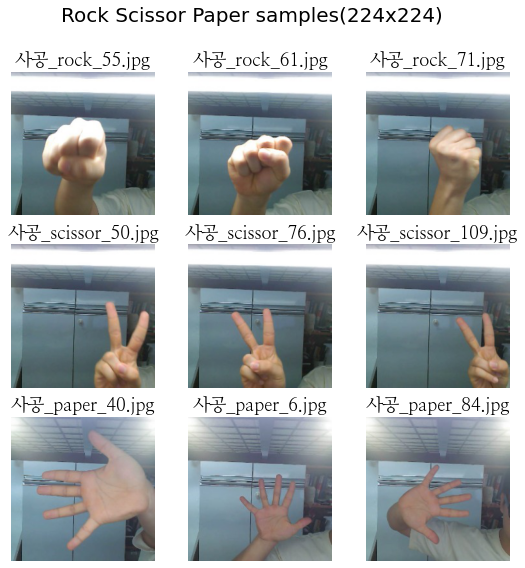

In [198]:
def get_image_sample(name, cls, sample=3):
    image_dir = os.path.join(base_dir, name, cls)
    image_list = glob.glob(image_dir + '/*.jpg')
    
    samples = random.sample(image_list, sample)
    
    return samples

rock_samples = get_image_sample('사공', 'rock')
scissor_samples = get_image_sample('사공', 'scissor')
paper_samples = get_image_sample('사공', 'paper')

sample_list = rock_samples + scissor_samples + paper_samples

plt.figure(figsize=(9,9))
plt.suptitle('Rock Scissor Paper samples(224x224)', fontsize=20)
for i, image_path in enumerate(sample_list):
    image = Image.open(image_path)
    filename = image_path.split('/')[-1]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(filename, fontproperties=fontprop)
    plt.axis('off')

## 0-1. 데이터 사이즈 변경
- MNIST 데이터와 같은 크기로 실습을 진행
- 변경된 원본을 저장하지 않고 바로 사용
 - 원본 : 224x224
 - 수정 : 28x28

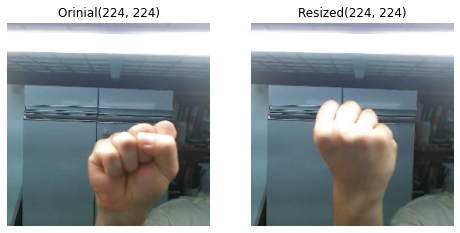

In [199]:
def resize_image(old_image, target_size=(224,224)):
    target_size = target_size
    new_image = old_image.resize(target_size, Image.ANTIALIAS)
    
    return new_image

sample_path = get_image_sample('사공', 'rock', sample=1)[0]
sample_image = Image.open(sample_path)
sample_resized = resize_image(example_image)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.imshow(sample_image)
plt.title(f'Orinial{sample_image.size}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sample_resized)
plt.title(f'Resized{sample_resized.size}')
plt.axis('off')

plt.show()

## 1. 데이터 불러오기
저장되어있는 이미지 데이터들을 불러오는 방법은 크게 2가지가 있다.
1. 노드를 통해 배운 PIL와 NumPy 라이브러리를 이용한 원시적인 방법
2. Tensorflow 라이브러리의 강력한 API를 이용한 방법

### 옵션
- '사공'과 '수완'의 데이터를 이용하여 학습해보자
- Train : '사공', Test : '수완'
- '수완' 데이터셋의 정확도가 매우 낮게 나온다는 평가가 있어서 선택

### 1-1. PIL와 NumPy 라이브러리를 이용한 방법
- Exploration 1-7노드에 있는 코드를 참고했다.
- <u>총 데이터가 달라져도 오류가 나지 않도록 수정했다.</u>

In [200]:
train_dir = os.path.join(base_dir, '사공')
test_dir = os.path.join(base_dir, '수완')

print(f'Train directory : {train_dir}')
print(f'Test directory : {test_dir}')

Train directory : /aiffel/aiffel/rock_scissor_paper/data/사공
Test directory : /aiffel/aiffel/rock_scissor_paper/data/수완


In [201]:
def load_data(img_path, norm=True): # 정규화 여부를 인자로 추가
    
    number_of_data = 0
    for dirpath, dirnames, filenames in os.walk(img_path): # 데이터의 총 개수을 계산한다.
        number_of_data += len(filenames)
    
    img_size=224
    color=3
    
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0 # 가위 : 0, 바위 : 1, 보 : 2
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx + 1

    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx + 1  
    
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = Image.open(file)
        resized_img = resize_image(img)
        imgs[idx,:,:,:] = np.array(resized_img, dtype=np.int32)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx + 1
        
    return imgs, labels

(x_train, y_train) = load_data(train_dir, norm=True)
(x_test, y_test) = load_data(test_dir, norm=True)
x_train = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
x_test = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print(f"x_train shape : {x_train.shape} / y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape} / y_test shape : {y_test.shape}")

x_train shape : (350, 224, 224, 3) / y_train shape : (350,)
x_test shape : (305, 224, 224, 3) / y_test shape : (305,)


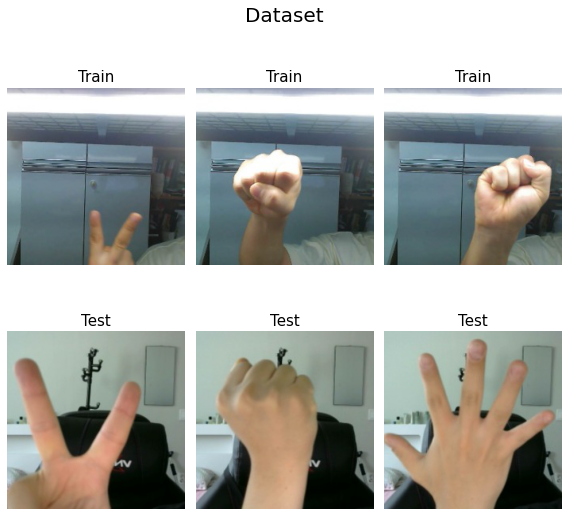

In [202]:
sample_train_images = [x_train[20], x_train[120], x_train[220]]
#sample_test_images = [x_train[20], x_train[120], x_train[220]]
sample_test_images = [x_test[20], x_test[120], x_test[220]]
sample_images = sample_train_images + sample_test_images

plt.figure(figsize=(8,8))
plt.suptitle("Dataset", fontsize=20)
for i, image in enumerate(sample_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title('Train' if i < 3 else 'Test', fontsize=15)
    plt.axis('off')   
    
plt.tight_layout()

## 2. 딥러닝 모델 설계
Tensorflow API를 이용해 가위바위보를 인식하는 딥러닝 모델을 설계
- 하이퍼파라미터를 바꿔가면서 성능이 가장 좋은 모델 찾기
- Classification분야에서 유명한 외부 모델 활용하기

In [208]:
import tensorflow as tf
from tensorflow import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                3211296   
_________________________________________________________________
dense_27 (Dense)             (None, 10)              

In [212]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'], )

history = model.fit(x_train, y_train, epochs=2, validation_split = 0.1, shuffle=True)

Epoch 1/2
10/10 [==============================] - 1s 71ms/step - loss: 0.6684 - accuracy: 0.6888 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 2/2
10/10 [==============================] - 0s 46ms/step - loss: 0.3231 - accuracy: 0.8328 - val_loss: 0.0438 - val_accuracy: 1.0000


In [213]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 4.4065 - accuracy: 0.3344
test_loss: 4.406538486480713 
test_accuracy: 0.33442622423171997


In [207]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


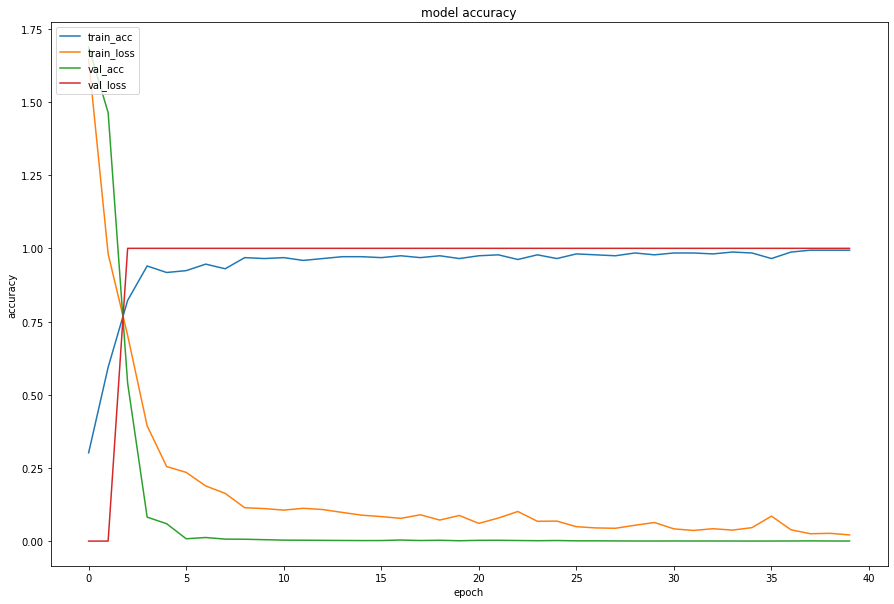

In [195]:
plt.figure(figsize=(15,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss', 'val_acc', 'val_loss'], loc='upper left')